# Compute EOF from scratch

In [1]:
import xarray as xr
import numpy as np
import pop_tools


import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
import cmocean.cm as cmo

In [2]:
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/bsf/'
bsf_filename = 'bsf_1301.017.nc'

In [3]:
# setting up of regional mask
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [45.0, 66.0], 'TLONG': [280.0, 360.0]}}],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}]}
mask3d = pop_tools.region_mask_3d(grid_name, 
                                  region_defs=region_defs, 
                                  mask_name='Subpolar Gyre')
mask3d = mask3d.sum('region')

ds = xr.open_dataset(path+bsf_filename).where(mask3d == 1).roll(nlon=-80)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
ds.BSF.isel(time=0, nlat=350, nlon=220).values

array(-13.328486, dtype=float32)

In [5]:
ds.TAREA.isel(nlat=350, nlon=220).values

array(2.35969834e+13)

In [6]:
# extract data
data = ds.BSF.isel(time=range(0,10)).values[:, 300:-10, 200:-30] 
# create weights -> grid cell area
weights = ds.TAREA.values[300:-10, 200:-30]*1e-4

# Apply spatial weighting
weighted_data = data * weights

#data.shape
#data = ds.BSF.isel(time=range(0,10)).values[:, 350:-30, 250:-50]
#data = ds.BSF.isel(time=0).values[300:-10, 200:-30]

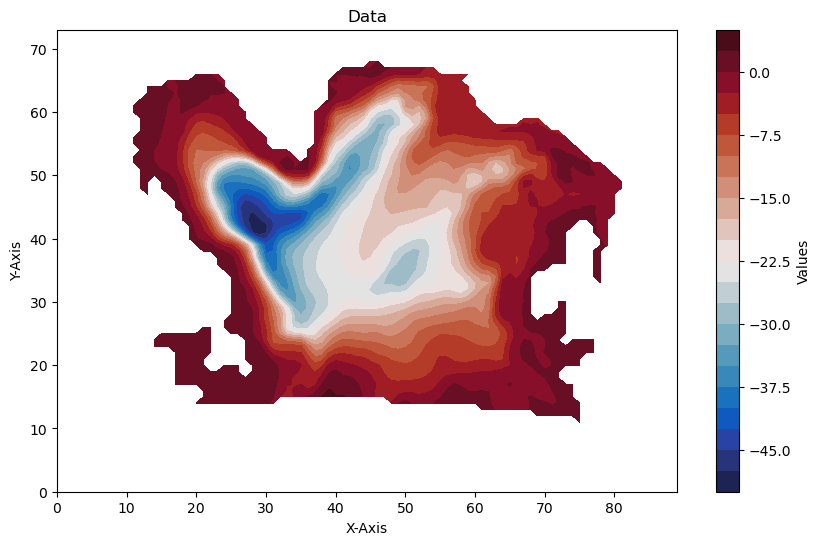

In [7]:
# Plot the EOFs with values using a contour plot
plt.figure(figsize=(10, 6))
plt.contourf(data[2,:,:], cmap=cmo.balance, levels=20)  # Adjust the colormap and levels as needed
plt.colorbar(label='Values')  # Add a colorbar to show the values
plt.title('Data')
plt.xlabel('')
plt.ylabel('Y-Axis')
plt.show()

### Perform EOF

In [34]:
# Reshape your data into a 2D array (time, space)
data_2d = weighted_data.reshape(10, -1)
#data_2d.shape

# Calculate the mean per time step along the time axis (axis=0)
mean_per_time_step = np.nanmean(data_2d, axis=1)
#print(mean_per_time_step)

# Find NaNs in your data
nan_indices = np.isnan(data_2d)

# Replace NaNs with the mean of the corresponding time step
data_2d[nan_indices] = np.take(mean_per_time_step, np.where(nan_indices)[0])

# Calculate the mean along the time axis
mean = np.mean(data_2d, axis=0)

# Subtract the mean to center the data
centered_data = data_2d - mean

In [35]:
# Calculate the covariance matrix
cov_matrix = np.cov(centered_data, rowvar=False)

# Perform eigen decomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

In [36]:
# Choose the number of principal components you want to keep (e.g., 3)
num_components = 3
principal_components = eigenvectors[:, :num_components]

# Project the data onto the principal components
projected_data = centered_data.dot(principal_components)
# 'projected_data' now contains your 2D geospatial data over time reduced to 'num_components' dimensions.

# If you want to reconstruct the data from the principal components:
reconstructed_data = projected_data.dot(principal_components.T) + mean
reconstructed_data[nan_indices] = np.nan

# Reshape the reconstructed data to the original shape
original_shape_data = reconstructed_data.reshape(10, 74, 90)

### Plot Principal component (PC) time series

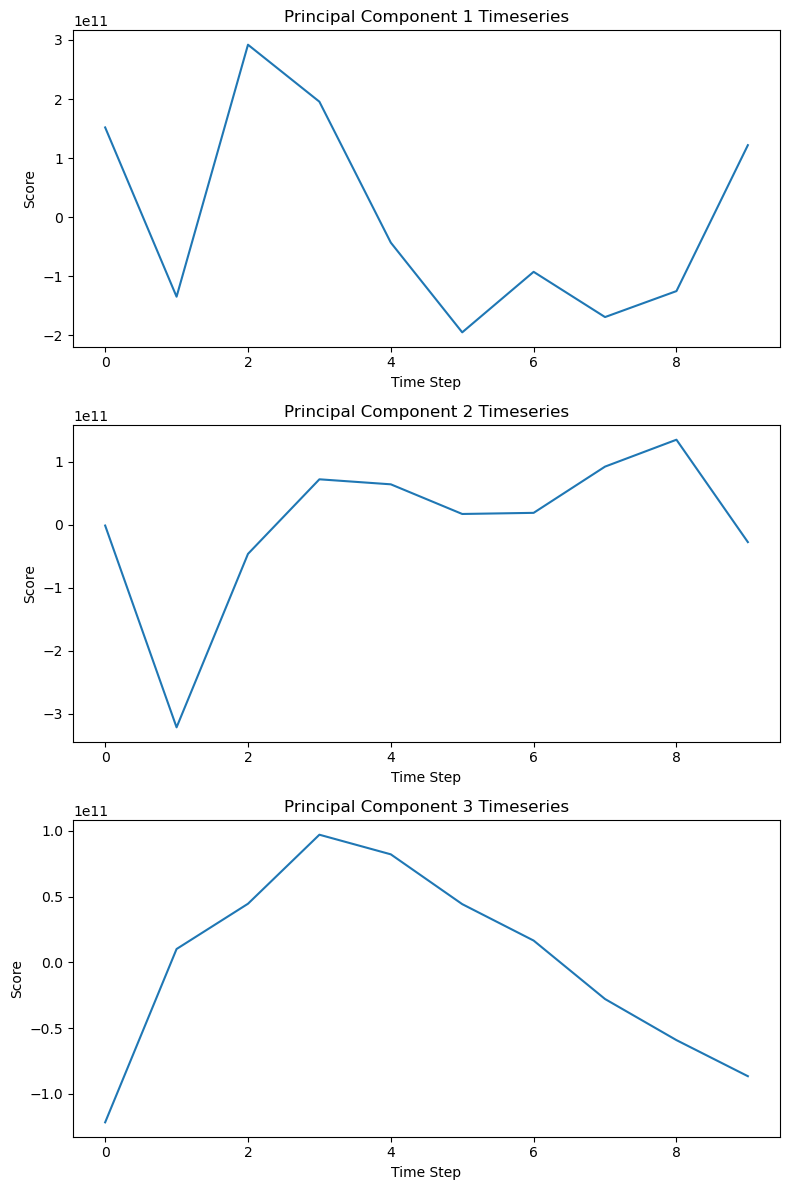

In [37]:
# Calculate the principal component scores (timeseries)
pcs = np.dot(eigenvectors.T, centered_data.T).T

# Create a time array
time = range(pcs.shape[0])  # Assuming each time step corresponds to an index

# Create subplots for each principal component
fig, axes = plt.subplots(num_components, 1, figsize=(8, 4 * num_components))

# Plot each principal component timeseries
for i in range(num_components):
    ax = axes[i]
    ax.plot(time, pcs[:, i], label=f'PC{i + 1}')
    ax.set_title(f'Principal Component {i + 1} Timeseries')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Score')

plt.tight_layout()
plt.show()

### Plot Empirical Orthogonal Functions


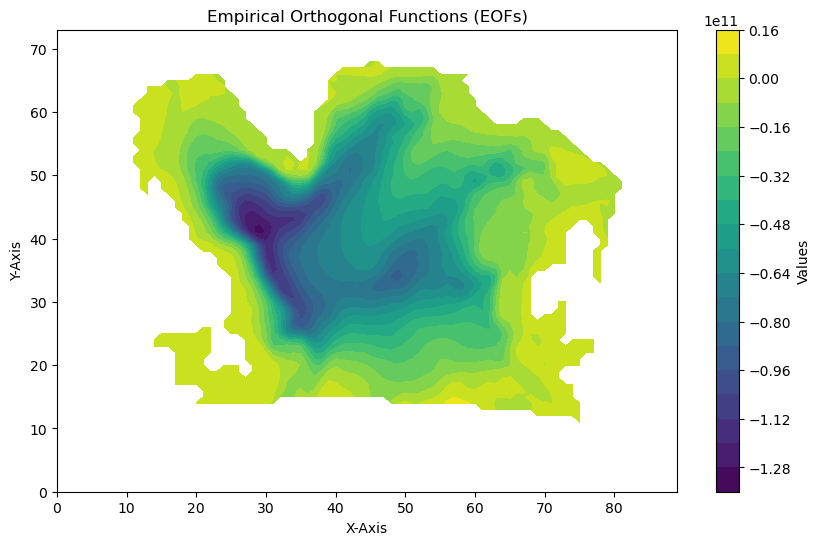

In [38]:
# Plot the EOFs with values using a contour plot
plt.figure(figsize=(10, 6))
plt.contourf(original_shape_data[2,:,:], cmap='viridis', levels=20)  # Adjust the colormap and levels as needed
plt.colorbar(label='Values')  # Add a colorbar to show the values
plt.title('Empirical Orthogonal Functions (EOFs)')
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.show()

# EOF index


In [46]:
# Choose the number of principal components you want to keep (e.g., 3)
num_components = 1
principal_components = eigenvectors[:, :num_components]

# Project the data onto the principal components
projected_data = centered_data.dot(principal_components)
# 'projected_data' now contains your 2D geospatial data over time reduced to 'num_components' dimensions.

# If you want to reconstruct the data from the principal components:
reconstructed_data = (projected_data.dot(principal_components.T) + mean)
reconstructed_data[nan_indices] = np.nan
# Reshape the reconstructed data to the original shape
original_shape_data = reconstructed_data.reshape(10, 74, 90)
original_shape_data = original_shape_data /weights
#reconstructed_data.shape



In [47]:
original_shape_data.shape

(10, 74, 90)

In [49]:

# Find the minimum per time step, considering the entire 2D spatial field
min_per_time_step = np.nanmin(original_shape_data, axis=(1,2))

In [50]:
min_per_time_step

array([-45.36649926, -40.94016651, -47.64158057, -46.07284367,
       -42.34220843, -40.01607523, -41.584847  , -40.41200156,
       -41.08537464, -44.87977053])